# Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,MelbourneAirport,18.0,26.9,21.4,7.0,8.9,SSE,41.0,W,SSE,...,95.0,54.0,1019.5,1017.0,8.0,5.0,18.5,26.0,Yes,0
1,Adelaide,17.2,23.4,0.0,NaN,NaN,S,41.0,S,WSW,...,59.0,36.0,1015.7,1015.7,NaN,NaN,17.7,21.9,No,0
2,Cairns,18.6,24.6,7.4,3.0,6.1,SSE,54.0,SSE,SE,...,78.0,57.0,1018.7,1016.6,3.0,3.0,20.8,24.1,Yes,0
3,Portland,13.6,16.8,4.2,1.2,0.0,ESE,39.0,ESE,ESE,...,76.0,74.0,1021.4,1020.5,7.0,8.0,15.6,16.0,Yes,1
4,Walpole,16.4,19.9,0.0,NaN,NaN,SE,44.0,SE,SE,...,78.0,70.0,1019.4,1018.9,NaN,NaN,17.4,18.1,No,0


## Run the pipeline

In [3]:
# Initialize atom and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, warnings=False, verbose=0)
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

In [4]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')


Training ========================= >>
Models: LGB
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9508
Test evaluation --> roc_auc: 0.8499
Time elapsed: 0.278s
-------------------------------------------------
Total time: 0.278s


Final results ==================== >>
Duration: 0.279s
-------------------------------------
LightGBM --> roc_auc: 0.8499


## Deep Feature Synthesis

In [5]:
# Since we are going to compare different datasets,
# we need to create separate branches
atom.branch = "dfs"

New branch dfs successfully created.


In [6]:
# Create 50 new features using DFS
atom.feature_generation("dfs", n_features=50, operators=["add", "sub", "log"])

Fitting FeatureGenerator...
Creating new features...
 --> 50 new features were added.


In [7]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

Series([], dtype: int64)

In [8]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...


In [9]:
# 50 new features may be to much...
# Let's check for multicollinearity and use RFECV to reduce the number
atom.feature_selection(
    strategy="RFECV",
    solver="LGB",
    n_features=30,
    scoring="auc",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature Location was removed due to low variance. Value 0.1744186046511628 repeated in 507863.0% of the rows.
 --> Feature Cloud3pm + RainToday_other was removed due to collinearity with another feature.
 --> Feature Cloud9am + WindGustDir was removed due to collinearity with another feature.
 --> Feature Cloud9am - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Evaporation - RainToday_No was removed due to collinearity with another feature.
 --> Feature Humidity3pm + WindDir9am was removed due to collinearity with another feature.
 --> Feature Humidity9am - RainToday_No was removed due to collinearity with another feature.
 --> Feature Humidity9am - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Location + Pressure3pm was removed due to collinearity with another feature.
 --> Feature Location + RainToday_No was removed due to collinearity with another feature.

In [10]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,Cloud3pm + RainToday_other,Cloud3pm,0.99957
1,Cloud9am + WindGustDir,Cloud9am,0.99978
2,Cloud9am - WindDir3pm,"Cloud9am, Cloud9am + WindGustDir","0.99981, 0.99938"
3,Evaporation - RainToday_No,Evaporation,0.99093
4,Humidity3pm + WindDir9am,"Humidity3pm, Evaporation - Humidity3pm","1.0, -0.99083"
5,Humidity9am - RainToday_No,Humidity9am,0.99979
6,Humidity9am - WindDir3pm,"Humidity9am, Humidity9am - RainToday_No","1.0, 0.99979"
7,Location + Pressure3pm,Pressure3pm,1.0
8,Location + RainToday_No,"RainToday_No, RainToday_Yes","1.0, -0.9881"
9,MaxTemp + RainToday_No,MaxTemp,0.99836


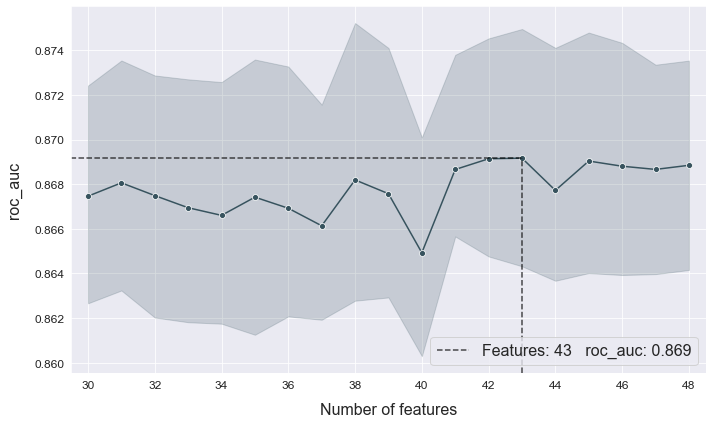

In [11]:
# After applying RFECV, we can plot the score per number of features
atom.plot_rfecv()

In [12]:
# Let's see how the model performs now
# Add a tag to the model's acronym to not overwrite previous LGB
atom.run("LGB_dfs")


Training ========================= >>
Models: LGB_dfs
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9937
Test evaluation --> roc_auc: 0.8733
Time elapsed: 0.506s
-------------------------------------------------
Total time: 0.506s


Final results ==================== >>
Duration: 0.507s
-------------------------------------
LightGBM --> roc_auc: 0.8733


## Genetic Feature Generation

In [13]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_master"

New branch gfg successfully created.


In [14]:
# Create new features using Genetic Programming
atom.feature_generation(strategy='GFG', n_features=20)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.16         0.134557        3         0.503453              N/A      9.26s
   1     3.14         0.341808        5         0.503638              N/A      9.30s
   2     3.58         0.438183        5         0.528541              N/A      8.49s
   3     3.82         0.476765        7         0.536112              N/A      7.99s
   4     5.15         0.502224        7         0.536112              N/A      7.55s
   5     5.82          0.49393        9         0.540632              N/A      7.08s
   6     6.99         0.497762        9         0.540632              N/A      6.66s
   7     8.20         0.496663        9         0.540632              N/A      6.20s
   8     9.04          0.49478        9        

In [15]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

,name,description,fitness
0,feature 25,"mul(sub(Sunshine, Humidity3pm), mul(WindGustSp...",0.531632
1,feature 26,"mul(mul(WindGustSpeed, sub(Sunshine, Humidity3...",0.531632


In [16]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ========================= >>
Models: LGB_gfg
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9528
Test evaluation --> roc_auc: 0.8568
Time elapsed: 0.343s
-------------------------------------------------
Total time: 0.344s


Final results ==================== >>
Duration: 0.344s
-------------------------------------
LightGBM --> roc_auc: 0.8568


## Analyze results

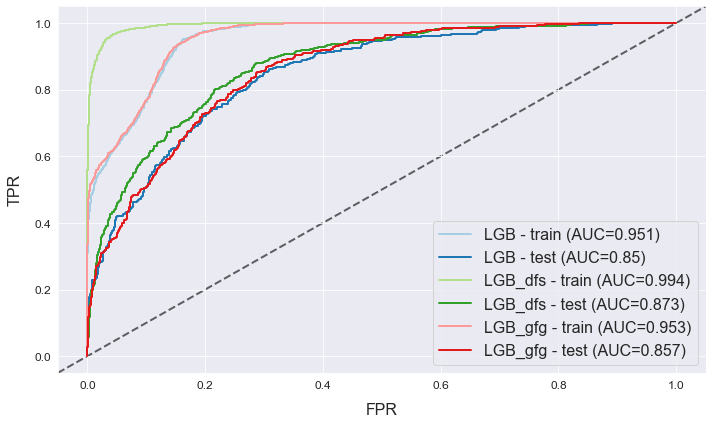

In [17]:
# Use atom's plots to compare the three models
atom.palette = "Paired"
atom.plot_roc(dataset="both")
atom.reset_aesthetics()

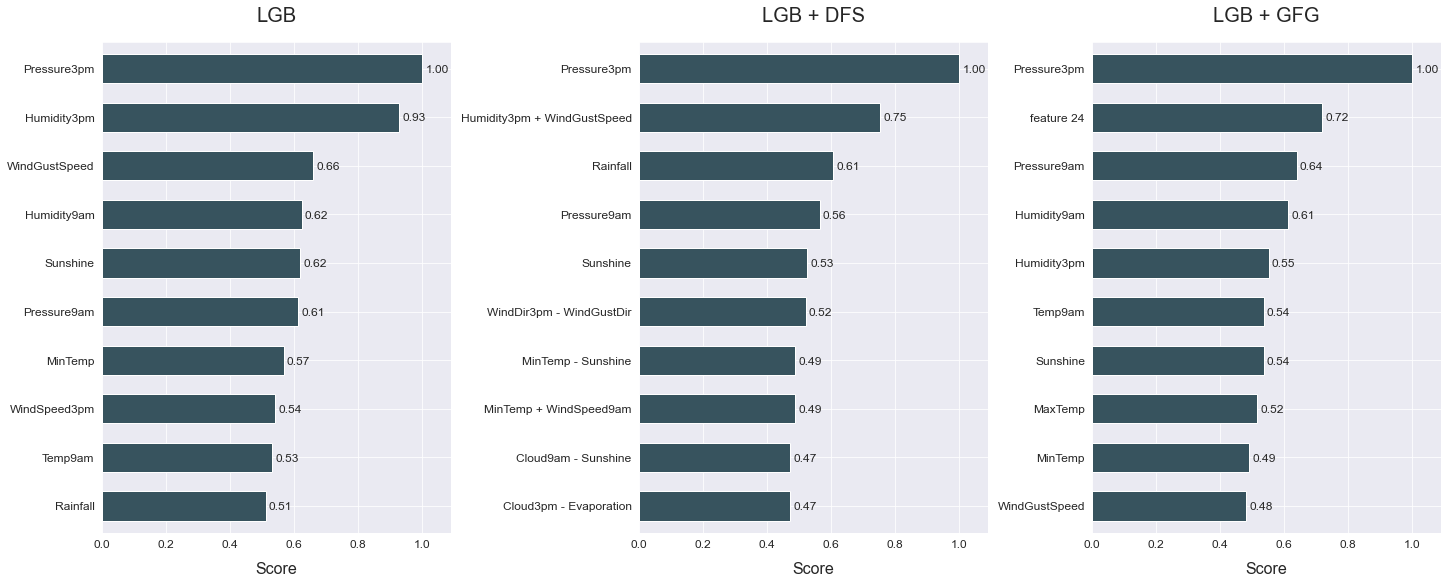

In [18]:
# For busy plots it might be useful to use a canvas
with atom.canvas(1, 3, figsize=(20, 8)):
    atom.lgb.plot_feature_importance(show=10, title="LGB")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + DFS")
    atom.lgb_gfg.plot_feature_importance(show=10, title="LGB + GFG")

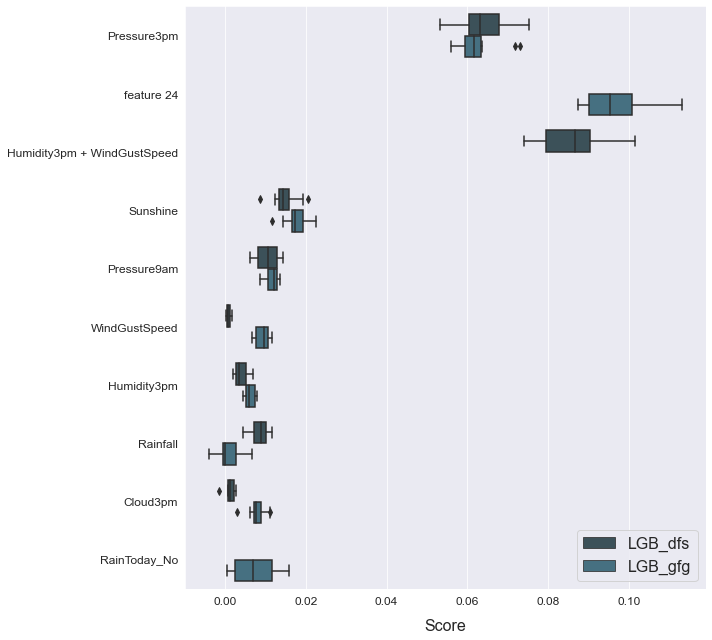

In [19]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_DFS", "LGB_GFG"], show=10)

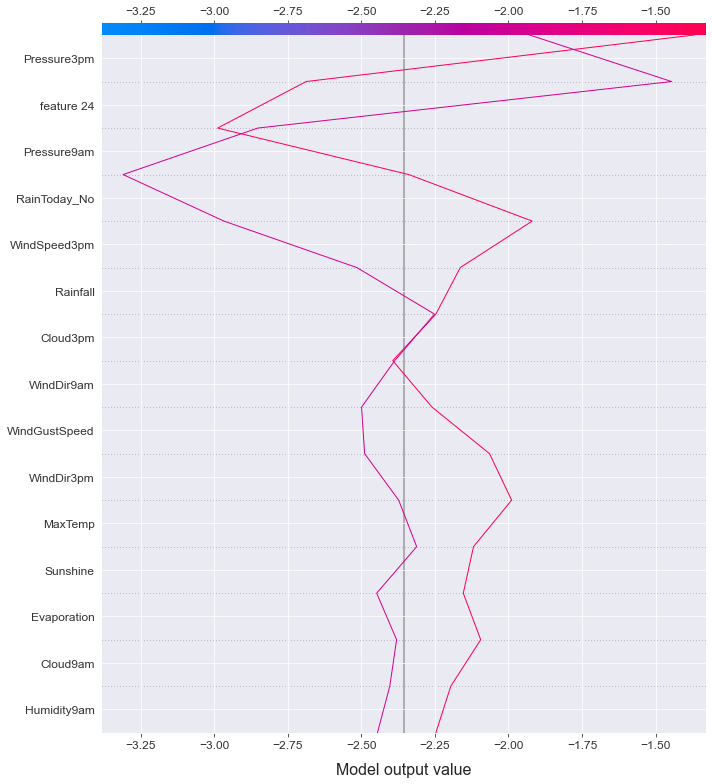

In [20]:
atom.LGB_gfg.decision_plot(index=(0, 10), show=15)